In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! git clone https://github.com/autonomousvision/stylegan_xl.git 
! pip install timm
! pip install ftfy
! pip install einops ninja
! pip install dill
! wget -c "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet512.pkl"

import sys
sys.path.append('./stylegan_xl')

import ast
import dnnlib
import h5py
import legacy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.linear_model import LinearRegression
import torch
from torch_utils import gen_utils
import torch.nn.functional as F

device = torch.device('cuda')
with dnnlib.util.open_url("imagenet512.pkl") as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Cloning into 'stylegan_xl'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 298 (delta 74), reused 51 (delta 51), pack-reused 209
Receiving objects: 100% (298/298), 13.88 MiB | 34.74 MiB/s, done.
Resolving deltas: 100% (141/141), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
def reconstruction(latents):
    latents = torch.from_numpy(np.repeat(latents, 37, axis=0).transpose(1, 0, 2)).to(device)
    for i in range(len(latents)):
        img = G.synthesis(latents[None, i], noise_mode="none")
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        img = Image.fromarray(img[0].cpu().numpy(), 'RGB')
        return img

In [5]:
import h5py

f1 = h5py.File("/content/drive/My Drive/images/GANs_StyleGAN_XL_normMUA.mat", "r")

# delete broken microelectrode array
x_te = np.delete(np.array(f1["test_MUA"]), np.arange(320, 384), axis=1)
x_tr = np.delete(np.array(f1["train_MUA"]), np.arange(320, 384), axis=1)
w_te = np.load("/content/drive/My Drive/images/w_te.npy")[:, 0]
w_tr = np.load("/content/drive/My Drive/images/w_tr.npy")[:, 0]
reg = LinearRegression().fit(x_tr, w_tr)
y_te = reg.predict(x_te)

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


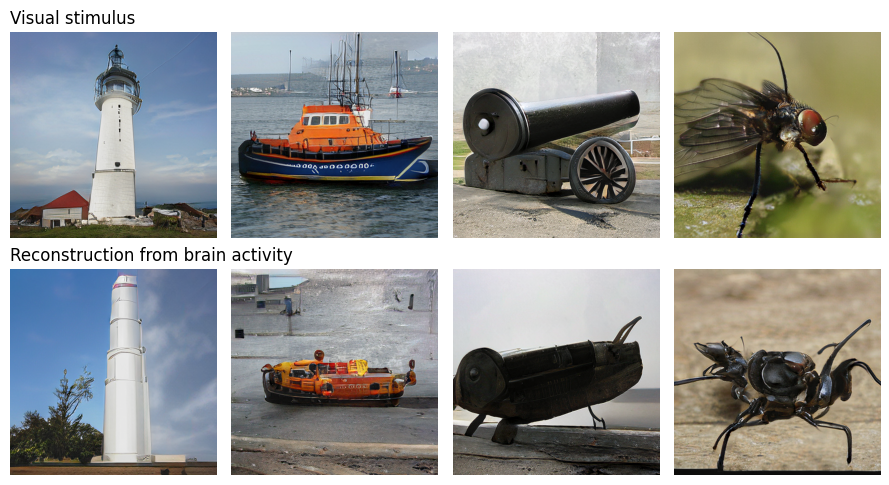

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(9, 5))
for i, index in enumerate([93, 196, 80, 113]):
    axs[0, i].imshow(reconstruction(w_te[index, None, None]))
    axs[0, i].axis("off")
    axs[0, 0].set_title("Visual stimulus", loc="left")
    axs[1, i].imshow(reconstruction(y_te[index, None, None]))
    axs[1, i].axis("off")
    axs[1, 0].set_title("Reconstruction from brain activity", loc="left")
plt.tight_layout()
plt.show()